In [1]:
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

## Load Dataset

In [2]:
(train_imgs,train_labels),(test_imgs,test_labels) = tf.keras.datasets.mnist.load_data(path="L:/Datasets/mnist.npz")

BufferSize = train_imgs.shape[0]
BatchSize = 200

train_imgs = tf.expand_dims(train_imgs,-1)
trainloader = tf.data.Dataset.from_tensor_slices((train_imgs,train_labels)).shuffle(BufferSize).batch(BatchSize)


In [3]:
train_imgs.shape

TensorShape([60000, 28, 28, 1])

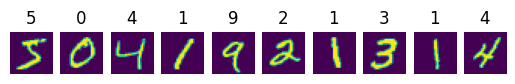

In [4]:
## View Img
def showBatchImg(images,labels,maxNum=5):
    fig, axes = plt.subplots(1, maxNum)
    for i in range(maxNum):
        axes[i].imshow(images[i].numpy().squeeze())
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')

showBatchImg(train_imgs, train_labels, 10)

## cGAN Model

Generator:  [noise+label] ==> Fake_Img  

Discriminator:  [Img + label] ==> if Real_Class ?

Loss: BCE(if Real&ClassMatch)


In [5]:
noise_len = 50

def Generator():  ## or: 3*3*128==>7*7*64==>14*14*32==>28*28*1
    seed = layers.Input(shape=(noise_len,))
    label = layers.Input(shape=((1,)))
    
    Embd = layers.Embedding(1,noise_len)(label)
    Embd = layers.Reshape((noise_len,))(Embd)
    x = layers.concatenate([seed,Embd])                           ## B*100
    # x = layers.Reshape((100,))(x)
    x = keras.Sequential(
    [
        layers.Dense(3*3*128,use_bias = False),                      ##  B*? ==> B*-
        layers.Reshape((3,3,128)),                                   ##      ==> B*3*3*128
        layers.BatchNormalization(), 
        layers.ReLU(),
        layers.Conv2DTranspose(64, 3, 2, use_bias=False),            ##      ==> B*7*7*64      ##  filters, kernel_size, strides
        layers.BatchNormalization(),                                                            ## = *strides + max(0,kernel_size-strides)
        layers.ReLU(),
        layers.Conv2DTranspose(32, 3, 2, padding="same", use_bias=False), ## ==> B*14*14*32     
        layers.BatchNormalization(), 
        layers.ReLU(),
        layers.Conv2DTranspose(1, 3, 2, padding="same", use_bias=False),  ## ==> B*28*28*1
        layers.Activation('tanh')
    ])(x)
    GModel = tf.keras.Model(inputs=[seed,label],outputs=x)
    return GModel

def Discriminator():
    label = layers.Input(shape=((1,)))
    img = layers.Input(shape=(28,28,1))

    Embd = layers.Embedding(1,28*28)(label)
    Embd = layers.Reshape((28,28,1))(Embd)
    x = layers.concatenate([img,Embd])                        ## B*28*28*2
    x = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3),strides=(2, 2), padding="same", use_bias=False),    ##  ==> B*14*14*32
        layers.BatchNormalization(), 
        layers.LeakyReLU(),
        layers.Dropout(0.5), 
        layers.Conv2D(64, (3, 3),strides=(2, 2), padding="same", use_bias=False),    ##  ==> B*7*7*64
        layers.BatchNormalization(), 
        layers.LeakyReLU(),
        layers.Dropout(0.5),  
        layers.Flatten(),                                                            ##  ==> B*3136
        layers.Dense(1)                                                              ## logits: 未被 Activation 处理
    ])(x)
    
    DModel = tf.keras.Model(inputs=[img,label],outputs=x)
    return DModel

# ## Call Model ##############################
# img = tf.ones((2, 28,28,1))
# seed = tf.ones((2, noise_len))
# label = tf.ones((2, 1))

# DModel = Discriminator()
# DModel((img,label)).shape

# GModel = Generator()
# GModel((seed,label)).shape

In [ ]:
DModel = Discriminator()
GModel = Generator()

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optG = tf.keras.optimizers.Adam(1e-3)
optD = tf.keras.optimizers.Adam(1e-5)

def lossDfn(predR,predF):
    lossR = bce(tf.ones_like(predR),predR)
    lossF = bce(tf.zeros_like(predF),predF)
    return lossR+lossF

def lossGfn(predF):
    return bce(tf.ones_like(predF),predF)

@tf.function
def trainStep(Images,Labels):
    Seeds = tf.random.normal([Labels.shape[0],noise_len])
    with tf.GradientTape() as tapeG, tf.GradientTape() as tapeD:
        FakeImgs = GModel((Seeds,Labels),training=True)
        predF = DModel((FakeImgs,Labels),training=True)
        predR = DModel((Images,Labels),training=True)
        lossG = lossGfn(predF)
        lossD = lossDfn(predR,predF)
    gradG = tapeG.gradient(lossG,GModel.trainable_variables) 
    gradD = tapeD.gradient(lossD,DModel.trainable_variables)
    optG.apply_gradients(zip(gradG,GModel.trainable_variables))
    optD.apply_gradients(zip(gradD,DModel.trainable_variables))
    return lossG,lossD

for epoch in range(20):
    counter = 0
    for _ , (Images,Labels) in enumerate(trainloader):
        lossG,lossD = trainStep(Images,Labels)
        counter += 1
        if counter%100 == 0:
            print(f'Epoch {epoch+1}----Generator Loss:: {lossG:>7f}----Discriminator Loss:: {lossD:>7f}')

In [ ]:
## Use 
test_num = 10

testlabel = np.ones(test_num)*2
testseed =tf.random.normal([test_num,noise_len])
FakeImgs = GModel((testseed,tf.convert_to_tensor(testlabel)),training=False)

showBatchImg(FakeImgs, testlabel)